In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load datasets
users = pd.read_csv("takehome_users.csv", encoding='latin-1')
engagement = pd.read_csv("takehome_user_engagement.csv")

# Convert timestamp to datetime
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])


In [8]:
# 1. Monthly Active Users (MAU)
# Extract year and month
engagement['year_month'] = engagement['time_stamp'].dt.to_period('M')

# Count unique active users per month
mau = engagement.groupby('year_month')['user_id'].nunique().reset_index()
mau.columns = ['Month', 'ActiveUsers']

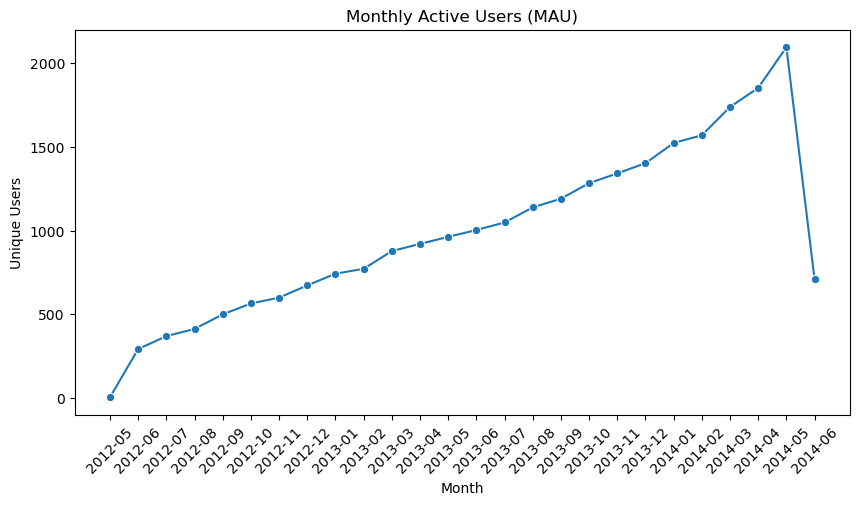

In [9]:
# Plot MAU
plt.figure(figsize=(10,5))
sns.lineplot(data=mau, x=mau['Month'].astype(str), y='ActiveUsers', marker='o')
plt.title('Monthly Active Users (MAU)')
plt.ylabel('Unique Users')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# 2. Churn Rate
# Define churn as not seen for 60+ days
last_seen = engagement.groupby('user_id')['time_stamp'].max().reset_index()
last_seen.columns = ['user_id', 'last_seen']
cutoff_date = engagement['time_stamp'].max() - pd.Timedelta(days=60)
last_seen['churned'] = last_seen['last_seen'] < cutoff_date

# Churn summary
total_users = last_seen.shape[0]
churned_users = last_seen['churned'].sum()
churn_rate = churned_users / total_users

print(f"\nTotal users: {total_users}")
print(f"Churned users: {churned_users}")
print(f"Churn rate: {churn_rate:.2%}")


Total users: 8823
Churned users: 6326
Churn rate: 71.70%


In [15]:
# 3. Simulated Customer Acquisition Cost (CAC)
import numpy as np
np.random.seed(42)
users['signup_channel'] = np.random.choice(['Adwords', 'Referral', 'Organic'], size=users.shape[0])

# Simulate cost per channel
channel_cost = {'Adwords': 20, 'Referral': 5, 'Organic': 2}
users['cac'] = users['signup_channel'].map(channel_cost)

# Average CAC
avg_cac = users['cac'].mean()
print(f"\nSimulated Average CAC: ${avg_cac:.2f}")


Simulated Average CAC: $9.10


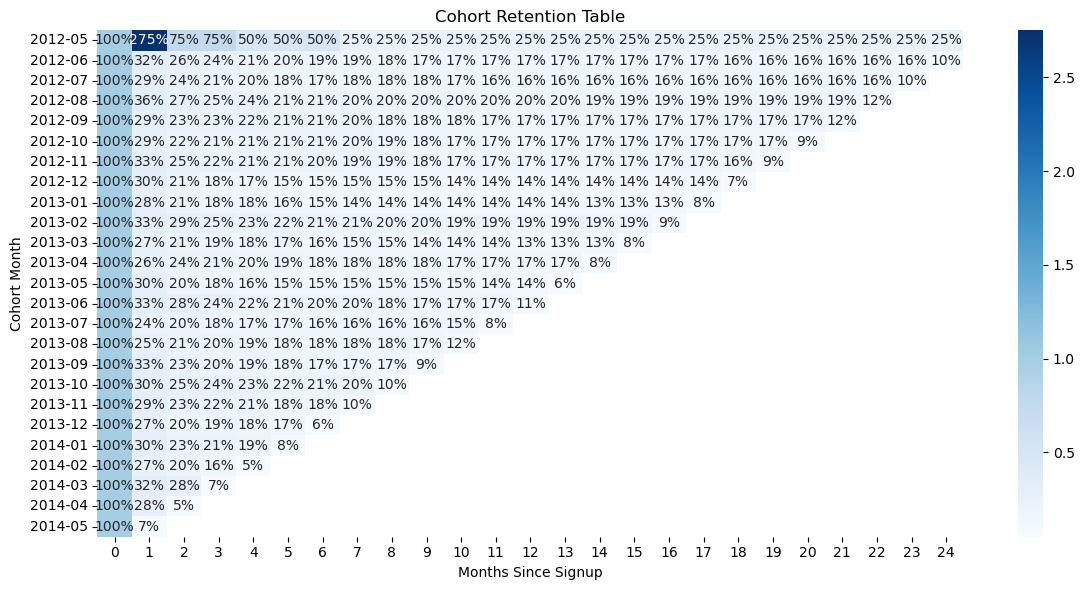

In [16]:
# 4. Cohort Retention Analysis

# Merge user signup time
users['creation_time'] = pd.to_datetime(users['creation_time'])
engagement = engagement.merge(users[['object_id', 'creation_time']], left_on='user_id', right_on='object_id')

# Create cohorts: signup month
engagement['cohort_month'] = engagement['creation_time'].dt.to_period('M')

# Active month: the month of interaction
engagement['activity_month'] = engagement['time_stamp'].dt.to_period('M')

# Create retention table
cohorts = engagement.groupby(['cohort_month', 'activity_month'])['user_id'].nunique().reset_index()
cohorts['period_index'] = (cohorts['activity_month'] - cohorts['cohort_month']).apply(lambda x: x.n)

cohort_pivot = cohorts.pivot(index='cohort_month', columns='period_index', values='user_id')

# Convert to percentage
cohort_size = cohort_pivot.iloc[:, 0]
retention = cohort_pivot.divide(cohort_size, axis=0)

# Plot retention heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(retention, annot=True, fmt='.0%', cmap='Blues')
plt.title('Cohort Retention Table')
plt.ylabel('Cohort Month')
plt.xlabel('Months Since Signup')
plt.tight_layout()
plt.show()